#### Check GPU

In [38]:
!nvidia-smi

/bin/bash: /home/djbacad/miniconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon May  8 23:32:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.50                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0  On |                  N/A |
| N/A   63C    P0               35W /  N/A|   5081MiB /  6144MiB |      2%      Default |
|                         

In [40]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Ensure reproducibility by setting global seed

In [41]:
tf.keras.backend.clear_session()
import random as rn
import numpy as np
SEED_VALUE = 888888
os.environ['TF_DETERMINISTIC_OPS'] = str(SEED_VALUE)
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
os.environ["CUDA_VISIBLE_DEVICES"] = str(SEED_VALUE)
rn.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(SEED_VALUE)
tf.config.experimental.enable_op_determinism()

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-05-08 23:32:22.711349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 23:32:22.711601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 23:32:22.711663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 23:32:22.712295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 23:32:22.712421: I tensorflow/core/co

#### Import libraries

In [42]:
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow_addons as tfa
import keras_cv
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

#### Initialize tunable hyperparameters

In [43]:
EPOCHS = 150
BATCH_SIZE = 16
IMG_SIZE = 224

#Optimizer HPs (Adabeleif):
INIT_LEARNING_RATE = 4e-3
TL_EPSILON = 1e-11
TL_WEIGHT_DECAY = 1e-2

#### Load the data and assign the train, val, and test sets

In [44]:
data_loc = '../data/vision'

# Train-Val Split: 70-30

# Train
train_set_raw = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="training",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Val
val_set_raw = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="validation",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Test
# Create the test set by breaking down the validation set.
val_batches = tf.data.experimental.cardinality(val_set_raw)
val_set_raw = val_set_raw.skip((2*val_batches) // 3)
test_set_raw = val_set_raw.take((2*val_batches) // 3)

Found 207 files belonging to 3 classes.
Using 145 files for training.
Found 207 files belonging to 3 classes.
Using 62 files for validation.


In [45]:
class_names = np.array(train_set_raw.class_names)
print(class_names)

['C' 'D' 'G']


#### Use buffered prefetching for performance

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set_raw.prefetch(buffer_size=AUTOTUNE)
val_set = val_set_raw.prefetch(buffer_size=AUTOTUNE)
test_set = test_set_raw.prefetch(buffer_size=AUTOTUNE)

#### Define the on-the-fly data augmentation steps

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(0.15,0.15),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.3),
  layers.RandomBrightness(factor=0.15),
  keras_cv.layers.RandomShear(0.15,0.12)
])

#### Create the base model

In [32]:
base_model = EfficientNetV2B0(weights='imagenet',
                             include_top=False, 
                             pooling='avg',
                             input_shape=(IMG_SIZE, IMG_SIZE, 3)) 


# Freeze
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

#### Attach the new top layers / classification head

In [33]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

2023-05-08 23:31:14.048415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 23:31:14.084264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

#### Define callbacks

In [19]:
# Record the weights from the epoch where val loss and val acc is at its lowest and highest respectively.

modelcheckpoint_vl = (
    ModelCheckpoint(filepath='../models/vision/min_val_loss.h5',
                    monitor='val_loss',
                    mode='min',
                    verbose=1,
                    save_best_only=True)
)

modelcheckpoint_va = (
    ModelCheckpoint(filepath='../models/vision/max_val_acc.h5',
                    monitor='val_acc',
                    mode='max',
                    verbose=1,
                    save_best_only=True)
)

#### Compile the model

In [20]:
optim = tfa.optimizers.AdaBelief(learning_rate=INIT_LEARNING_RATE,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer=optim,
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_______________________________________________

#### Train the model

In [22]:
history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=val_set,
                    callbacks = [modelcheckpoint_vl, modelcheckpoint_va],
                    )

Epoch 1/150


2023-05-08 23:06:07.048583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [145]
	 [[{{node Placeholder/_4}}]]
2023-05-08 23:06:07.049059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [145]
	 [[{{node Placeholder/_4}}]]


2023-05-08 23:06:07.851799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 23:06:07.904308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

2023-05-08 23:06:12.789266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 23:06:12.848711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

10/10 [==============================] - ETA: 0s - loss: 1.3099 - acc: 0.3241

2023-05-08 23:06:24.955355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [62]
	 [[{{node Placeholder/_0}}]]
2023-05-08 23:06:24.956083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [62]
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.19429, saving model to ../models/vision/min_val_loss.h5
10/10 [==============================] - 22s 518ms/step - loss: 1.3099 - acc: 0.3241 - val_loss: 1.1943 - val_acc: 0.3333
Epoch 2/150
 9/10 [==========================>...] - ETA: 0s - loss: 1.2510 - acc: 0.3125
Epoch 2: val_loss improved from 1.19429 to 1.14727, saving model to ../models/vision/min_val_loss.h5
10/10 [==============================] - 2s 220ms/step - loss: 1.2574 - acc: 0.3103 - val_loss: 1.1473 - val_acc: 0.3333
Epoch 3/150
10/10 [==============================] - ETA: 0s - loss: 1.0832 - acc: 0.4552
Epoch 3: val_loss improved from 1.14727 to 1.05203, saving model to ../models/vision/min_val_loss.h5
10/10 [==============================] - 2s 221ms/step - loss: 1.0832 - acc: 0.4552 - val_loss: 1.0520 - val_acc: 0.4000
Epoch 4/150
 9/10 [==========================>...] - ETA: 0s - loss: 1.1067 - acc: 0.4306
Epoch 4: val_loss improved from 1.05203 to 1.04255, saving model t

### Visualize accuracy and loss

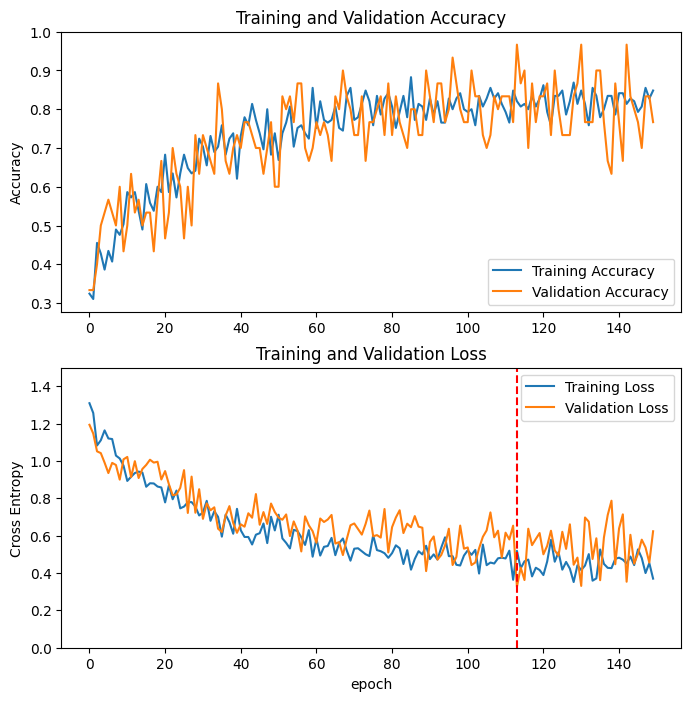

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


loss = history.history['loss']
val_loss = history.history['val_loss']
min_value = min(val_loss)
min_index = val_loss.index(min_value)
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.axvline(x=min_index, c = 'r', ls = '--')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
best_model = tf.keras.models.load_model('../models/vision/min_val_loss.h5')


2023-05-08 23:12:21.710437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 23:12:21.753867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

2023-05-08 23:12:25.559428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-08 23:12:25.617830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform_1/strided_slice' wi

### Check accuracy on test set

In [39]:
print('Testing Accuracy: ',(best_model.evaluate(test_set_raw))[1]*100, '%')

1/1 [==============================] - 0s 208ms/step - loss: 0.7510 - acc: 0.8125
Testing Accuracy:  81.25 %
